Try training on GHZ state using data in random bases

In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor, build_ghz_plus

Pick system size, dimensionality of local hilbert space, and initial bond dim

In [3]:
L=4
local_dim=2
bond_dim=2

Initialize the MPS model

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

The ground truth state (a ghz state with no phase)

In [5]:
ghz_plus = build_ghz_plus(L)

Samples_tr: lists indices of the observed basis states at each measurement. 0 = spin up, 1 = spin down

settings: array of corresponding angles

In [6]:
fname_settings = "datasets/settings_ghz_plus_random_basis_L=%d.npy"%L
fname_samples = "datasets/samples_ghz_plus_random_basis_L=%d.npy"%L
samples = np.load(fname_samples)
samples_tr = torch.tensor((1-samples)/2).to(torch.long)
settings = np.load(fname_settings)

In [7]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [8]:
from qtools import pauli_exp

Holds the unitaries corresponding to each angle

In [9]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [10]:
from torch.utils.data import TensorDataset, DataLoader

In [11]:
from models import MeasurementDataset, ComplexTensor

A dataset which yields outcomes and corresponding rotations

In [12]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

Batch size and learning rate for training:

In [13]:
batch_size = 256
lr = 1e-2

In [14]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [15]:
fidelities=[]
losses = []
ghz_losses = []

Number of epochs of training

In [16]:
eps = 5

How many grad-descent steps to perform at each bond

In [17]:
nstep=1

Max number of singular values to keep, and cutoff below which to truncate singular values

In [18]:
max_sv = None
cutoff=1e-8

In [19]:
amp1 = []
amp2 = []

Regularization term: penalty for Renyi-2 entropy, here set to zero

In [20]:
s2_schedule = np.concatenate([np.linspace(.0, 0, (eps-1) * len(dl)), np.zeros(len(dl))])

In [21]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        #get torch tensors representing measurement outcomes, and corresponding local unitaries
        spinconfig = inputs['samples']
        rot = inputs['rotations']
        rotations = ComplexTensor(rot['real'], rot['imag'])
        
        s2_penalty = s2_schedule[ep*len(dl) + step]
        #forward sweep across the chain
        for i in range(L-1):
            for __ in range(nstep):
                #computes merged two-site tensor at bond i, and the gradient of NLL cost function
                # with respect to this 'blob'; updates merged tensor accordingly, then breaks back to local tensors
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='left',max_sv_to_keep=max_sv, 
                                       learning_rate=lr, s2_penalty=s2_penalty)   
        #backward sweep across the chain
        for i in range(L-2, -1,-1):
            for __ in range(nstep):
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='right',max_sv_to_keep=max_sv, 
                                       learning_rate=lr, s2_penalty=s2_penalty)   
        with torch.no_grad():
            #record batched loss functions
            losses.append(psi.nll_loss(spinconfig,rotation=rotations))
            ghz_losses.append(ghz_plus.nll_loss(spinconfig, rotation=rotations))
            
            #check the relative phase between the two relevant basis states
            s1 = torch.tensor([1,0]* (L//2),dtype=torch.long)
            s2 = torch.tensor([0,1] * (L//2),dtype=torch.long)
            a1 = psi.amplitude_normalized(s1).numpy().item()
            a2 = psi.amplitude_normalized(s2).numpy().item()
            amp1.append(a1)
            amp2.append(a2)

            #check the fidelity onto ghz state
            f = np.abs(psi.overlap(ghz_plus)) / psi.norm().numpy()
            fidelities.append(f)


    print("finished epoch %d" % ep)

        

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4


In [22]:
import matplotlib.pyplot as plt

In [23]:
fidelities = np.abs(np.asarray(fidelities))

In [24]:
import datetime

In [25]:
t = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

Text(0.5,1,'batch NLL loss 2019-04-30_20:21:30')

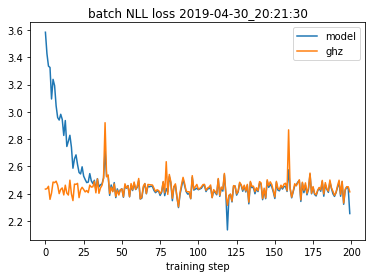

In [26]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(losses, label='model')
plt.plot(ghz_losses, label='ghz')
plt.legend()
plt.xlabel("training step")
plt.title("batch NLL loss %s" % t)
# fig.savefig("assets/nll_loss_example_{0}.png".format(t))

Text(0.5,1,'fidelity')

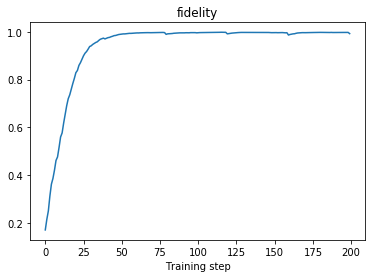

In [39]:
plt.plot(fidelities)
plt.xlabel("Training step")
plt.title("fidelity")

In [28]:
amp1 = np.asarray(amp1)
amp2 = np.asarray(amp2)
phi1 = np.angle(amp1,deg=True)
phi2 = np.angle(amp2,deg=True)
dphi = phi1-phi2

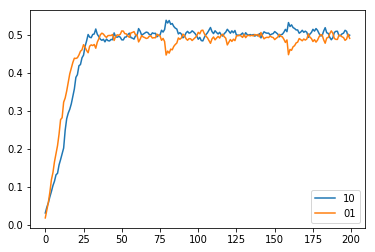

In [29]:
fig, ax = plt.subplots()
plt.plot(np.abs(amp1)**2, label="10")
plt.plot(np.abs(amp2)**2, label="01")
plt.legend()

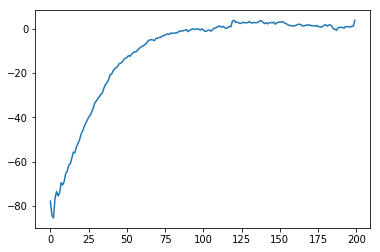

In [30]:
fig, ax = plt.subplots()
plt.plot(dphi)

In [31]:
from tools import generate_binary_space

In [32]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [33]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1, 1, 1]) has probability 0.0002
tensor([1, 1, 1, 0]) has probability 0.0005
tensor([1, 1, 0, 1]) has probability 0.0011
tensor([1, 1, 0, 0]) has probability 0.0001
tensor([1, 0, 1, 1]) has probability 0.0026
tensor([1, 0, 1, 0]) has probability 0.4988
tensor([1, 0, 0, 1]) has probability 0.0004
tensor([1, 0, 0, 0]) has probability 0.0004
tensor([0, 1, 1, 1]) has probability 0.0017
tensor([0, 1, 1, 0]) has probability 0.0004
tensor([0, 1, 0, 1]) has probability 0.4903
tensor([0, 1, 0, 0]) has probability 0.0005
tensor([0, 0, 1, 1]) has probability 0.0010
tensor([0, 0, 1, 0]) has probability 0.0014
tensor([0, 0, 0, 1]) has probability 0.0003
tensor([0, 0, 0, 0]) has probability 0.0003


In [37]:
with torch.no_grad():
    for i in range(len(basis)):
        a = psi.amplitude_normalized(basis[i])
        atrue = ghz_plus.amplitude_normalized(basis[i])
        print("{0} has amplitude {1:.4f} (target: {2:.4f})".format(basis[i], a.numpy().item(),
                                                                         atrue.numpy().item()))

tensor([1, 1, 1, 1]) has amplitude 0.0011+0.0134j (target: 0.0000+0.0000j)
tensor([1, 1, 1, 0]) has amplitude -0.0172-0.0152j (target: 0.0000+0.0000j)
tensor([1, 1, 0, 1]) has amplitude -0.0308+0.0120j (target: 0.0000+0.0000j)
tensor([1, 1, 0, 0]) has amplitude -0.0057+0.0095j (target: 0.0000+0.0000j)
tensor([1, 0, 1, 1]) has amplitude -0.0031-0.0507j (target: 0.0000+0.0000j)
tensor([1, 0, 1, 0]) has amplitude 0.7013+0.0832j (target: 0.7071+0.0000j)
tensor([1, 0, 0, 1]) has amplitude -0.0129+0.0166j (target: 0.0000+0.0000j)
tensor([1, 0, 0, 0]) has amplitude 0.0165-0.0124j (target: 0.0000+0.0000j)
tensor([0, 1, 1, 1]) has amplitude -0.0270+0.0309j (target: 0.0000+0.0000j)
tensor([0, 1, 1, 0]) has amplitude 0.0128-0.0138j (target: 0.0000+0.0000j)
tensor([0, 1, 0, 1]) has amplitude 0.6992+0.0374j (target: 0.7071+0.0000j)
tensor([0, 1, 0, 0]) has amplitude -0.0195-0.0122j (target: 0.0000+0.0000j)
tensor([0, 0, 1, 1]) has amplitude 0.0145+0.0280j (target: 0.0000+0.0000j)
tensor([0, 0, 1, 0